In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(111)

# 加载数据
train_path = "C:/Users/Cherry/Desktop/Midtermdata/ruc_Class25Q1_train.csv"
test_path = "C:/Users/Cherry/Desktop/Midtermdata/ruc_Class25Q1_test.csv"
community_path = "C:/Users/Cherry/Desktop/Midtermdata/ruc_Class25Q1_details.csv"
rent_path = "C:/Users/Cherry/Desktop/Midtermdata/ruc_Class25Q1_rent.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
community_data = pd.read_csv(community_path)
rent_data = pd.read_csv(rent_path)

print("训练集形状:", train_data.shape)
print("测试集形状:", test_data.shape)
print("小区数据形状:", community_data.shape)
print("租金数据形状:", rent_data.shape)

训练集形状: (84133, 32)
测试集形状: (14786, 32)
小区数据形状: (3100, 27)
租金数据形状: (84150, 23)



-------------------- 训练数据 --------------------
数据形状: (84133, 32)
缺失值数量:
Unnamed: 0        0
城市                0
区域                0
板块                0
环线            41407
小区名称              0
价格                0
房屋户型            605
所在楼层              0
建筑面积              0
套内面积          58987
房屋朝向              0
建筑结构            605
装修情况            605
梯户比例           1695
配备电梯           8315
别墅类型          83384
交易时间              0
交易权属              0
上次交易          28953
房屋用途              2
房屋年限          29782
产权所属              0
抵押信息          84133
房屋优势          16064
核心卖点          16366
户型介绍          63671
周边配套          34027
交通出行          32437
lon               0
lat               0
年份                0
dtype: int64
价格统计:
count    8.413300e+04
mean     1.971953e+06
std      2.639962e+06
min      7.828000e+04
25%      6.974000e+05
50%      1.146500e+06
75%      2.176000e+06
max      7.995000e+07
Name: 价格, dtype: float64


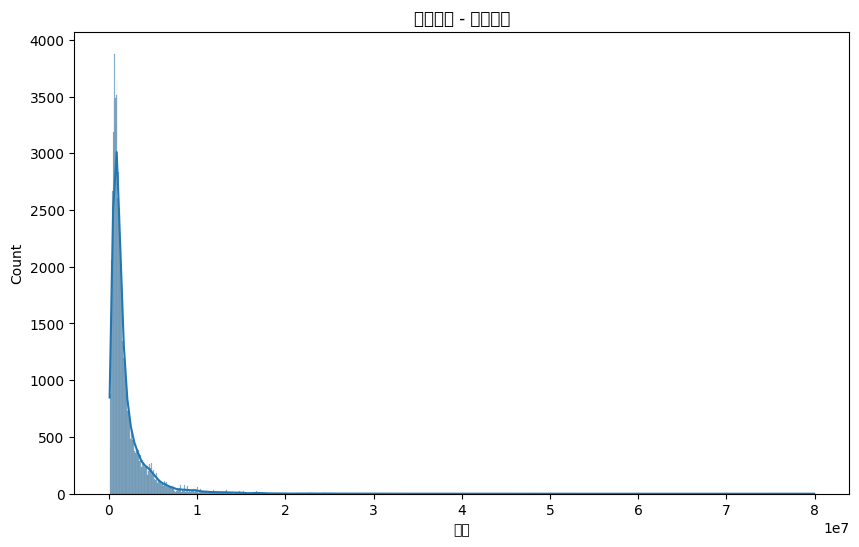

价格下界: -19060234.50000006, 上界: 32259857.5000001
移除异常值前的样本数: 84604
移除异常值后的样本数: 84562
移除的样本数: 42
训练集特征形状: (67649, 29)
验证集特征形状: (16913, 29)

线性回归 (OLS) 评估结果:
训练集 MAE: 544469.49
验证集 MAE: 544234.35
6折交叉验证 MAE: 1009872.61

Lasso回归 评估结果:
训练集 MAE: 544501.54
验证集 MAE: 544259.14
6折交叉验证 MAE: 993486.34

岭回归 评估结果:
训练集 MAE: 541384.32
验证集 MAE: 540840.92
6折交叉验证 MAE: 1054899.82

弹性网 评估结果:
训练集 MAE: 539665.09
验证集 MAE: 538905.43
6折交叉验证 MAE: 977192.69

最佳Ridge alpha参数: 100

最佳岭回归 评估结果:
训练集 MAE: 532727.39
验证集 MAE: 531600.28
6折交叉验证 MAE: 1017047.38

带非线性特征的最佳岭回归 评估结果:
训练集 MAE: 532727.39
验证集 MAE: 531600.28
6折交叉验证 MAE: 1017047.38

模型性能比较：
               模型         训练集MAE         验证集MAE       交叉验证MAE
5      ElasticNet  539665.092665  538905.427729  9.771927e+05
1           Lasso  544501.544142  544259.142295  9.934863e+05
0             OLS  544469.487385  544234.352608  1.009873e+06
3         最佳Ridge  532727.392486  531600.281148  1.017047e+06
4  带非线性特征的最佳Ridge  532727.392486  531600.281148  1.017047e+06
2        

ValueError: array length 14897 does not match index length 14786

In [4]:
# 数据预处理和探索性分析
def explore_data(df, title):
    print(f"\n{'-'*20} {title} {'-'*20}")
    print(f"数据形状: {df.shape}")
    print(f"缺失值数量:\n{df.isnull().sum()}")
    
    if '价格' in df.columns:
        print(f"价格统计:\n{df['价格'].describe()}")
        plt.figure(figsize=(10, 6))
        sns.histplot(df['价格'], kde=True)
        plt.title(f"{title} - 价格分布")
        plt.show()

# 探索训练数据
explore_data(train_data, "训练数据")

# 数据清洗和预处理
def preprocess_data(df):
    # 复制数据框以避免修改原始数据
    data = df.copy()
    
    # 处理缺失值
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            if data[col].dtype == 'object':
                data[col] = data[col].fillna('未知')
            else:
                data[col] = data[col].fillna(data[col].median())
    
    # 提取有用的特征
    # 处理建筑面积
    if '建筑面积' in data.columns:
        data['建筑面积'] = data['建筑面积'].astype(str)
        data['建筑面积'] = data['建筑面积'].str.extract('([\d\.]+)').astype(float)
    
    # 处理套内面积
    if '套内面积' in data.columns:
        data['套内面积'] = data['套内面积'].astype(str)
        data['套内面积'] = data['套内面积'].str.extract('([\d\.]+)').astype(float)
    
    # 处理房屋户型，提取房间数和厅数
    if '房屋户型' in data.columns:
        data['房间数'] = data['房屋户型'].str.extract('(\d+)室').fillna(0).astype(int)
        data['厅数'] = data['房屋户型'].str.extract('(\d+)厅').fillna(0).astype(int)
        data['卫数'] = data['房屋户型'].str.extract('(\d+)卫').fillna(0).astype(int)
    
    # 处理楼层信息
    if '所在楼层' in data.columns:
        # 提取总楼层数
        data['总楼层'] = data['所在楼层'].str.extract('共(\d+)层').fillna(0).astype(int)
        
        # 判断是否为高层/中层/低层
        data['是否高层'] = data['所在楼层'].str.contains('高楼层').astype(int)
        data['是否中层'] = data['所在楼层'].str.contains('中楼层').astype(int)
        data['是否低层'] = data['所在楼层'].str.contains('低楼层').astype(int)
    
    # 处理电梯信息
    if '配备电梯' in data.columns:
        data['有电梯'] = (data['配备电梯'] == '有').astype(int)
    
    # 处理朝向信息，提取南北通透
    if '房屋朝向' in data.columns:
        data['朝南'] = data['房屋朝向'].str.contains('南').astype(int)
        data['朝北'] = data['房屋朝向'].str.contains('北').astype(int)
        data['朝东'] = data['房屋朝向'].str.contains('东').astype(int)
        data['朝西'] = data['房屋朝向'].str.contains('西').astype(int)
        data['南北通透'] = ((data['朝南'] == 1) & (data['朝北'] == 1)).astype(int)
    
    # 处理装修情况
    if '装修情况' in data.columns:
        decoration_map = {
            '精装修': 3,
            '简装修': 2,
            '毛坯房': 1,
            '未知': 0
        }
        data['装修评分'] = data['装修情况'].map(decoration_map)
    
    # 提取更多特征
    if '建筑面积' in data.columns and '套内面积' in data.columns:
        data['公摊比例'] = 1 - (data['套内面积'] / data['建筑面积'])
        data.loc[data['公摊比例'] < 0, '公摊比例'] = np.nan
        data.loc[data['公摊比例'] > 1, '公摊比例'] = np.nan
        data['公摊比例'] = data['公摊比例'].fillna(data['公摊比例'].median())
    
    # 将环线信息转换为数值
    if '环线' in data.columns:
        data['环线数值'] = data['环线'].str.extract('(\d+)环').fillna(0).astype(int)
        # 对于非数字环线，设置特殊值
        data.loc[data['环线'].str.contains('内'), '环线数值'] = 1
        data.loc[data['环线'].str.contains('外'), '环线数值'] = 10
    
    return data

# 处理训练数据和测试数据
processed_train = preprocess_data(train_data)
processed_test = preprocess_data(test_data)

# 合并小区详细数据
def merge_community_data(df, community_df):
    # 规范化小区名称
    df['小区名称_clean'] = df['小区名称'].str.strip()
    community_df['名称_clean'] = community_df['名称'].str.strip()
    
    # 合并数据
    merged = df.merge(community_df, left_on=['小区名称_clean', '城市'], 
                      right_on=['名称_clean', '城市'], how='left')
    
    # 提取容积率和绿化率
    if '容 积 率' in merged.columns:
        merged['容积率'] = merged['容 积 率'].astype(str).str.extract('([\d\.]+)').astype(float)
    
    if '绿 化 率' in merged.columns:
        merged['绿化率'] = merged['绿 化 率'].astype(str).str.extract('([\d\.]+)').astype(float)
    
    # 提取建筑年代
    if '建筑年代' in merged.columns:
        merged['建筑年代'] = merged['建筑年代'].astype(str).str.extract('(\d+)').astype(float)
        merged['建筑年限'] = 2025 - merged['建筑年代']  # 假设当前年份为2025
    
    return merged

# 合并小区数据
train_with_community = merge_community_data(processed_train, community_data)
test_with_community = merge_community_data(processed_test, community_data)

# 合并租金数据
def add_rent_features(df, rent_df):
    # 按小区名称和城市分组计算平均租金
    rent_agg = rent_df.groupby(['小区名称', '城市'])['价格'].agg(['mean', 'median', 'count']).reset_index()
    rent_agg.columns = ['小区名称', '城市', '平均租金', '租金中位数', '租金数据量']
    
    # 合并到主数据框
    df_with_rent = df.merge(rent_agg, on=['小区名称', '城市'], how='left')
    
    # 填充缺失值
    df_with_rent['平均租金'] = df_with_rent['平均租金'].fillna(df_with_rent['平均租金'].median())
    df_with_rent['租金中位数'] = df_with_rent['租金中位数'].fillna(df_with_rent['租金中位数'].median())
    df_with_rent['租金数据量'] = df_with_rent['租金数据量'].fillna(0)
    
    # 如果有房价数据，计算租金比率
    if '价格' in df.columns:
        df_with_rent['租售比'] = df_with_rent['平均租金'] * 12 / df_with_rent['价格']
        # 处理异常值
        df_with_rent.loc[df_with_rent['租售比'] > 0.2, '租售比'] = 0.2  # 租售比通常不会太高
        df_with_rent.loc[df_with_rent['租售比'] < 0.01, '租售比'] = 0.01  # 租售比通常不会太低
    
    return df_with_rent

# 合并租金数据
train_final = add_rent_features(train_with_community, rent_data)
test_final = add_rent_features(test_with_community, rent_data)

# 特征选择
def select_features(df, target_col=None):
    # 选择数值型特征
    numeric_features = [
        '建筑面积', '套内面积', '房间数', '厅数', '卫数', '总楼层', 
        '是否高层', '是否中层', '是否低层', '有电梯', '朝南', '朝北', 
        '朝东', '朝西', '南北通透', '装修评分', '公摊比例', '环线数值',
        '平均租金', '租金中位数', '租金数据量', 'lon', 'lat'
    ]
    
    # 如果存在小区数据中的特征，也加入
    additional_features = ['容积率', '绿化率', '建筑年限']
    for feat in additional_features:
        if feat in df.columns:
            numeric_features.append(feat)
    
    # 选择分类特征
    categorical_features = ['区域', '板块', '建筑结构', '交易权属', '房屋用途']
    
    # 去除不在dataframe中的特征
    numeric_features = [f for f in numeric_features if f in df.columns]
    categorical_features = [f for f in categorical_features if f in df.columns]
    
    # 构建特征集
    features = {}
    features['numeric'] = numeric_features
    features['categorical'] = categorical_features
    
    # 如果有目标列，返回X和y
    if target_col and target_col in df.columns:
        X = df[numeric_features + categorical_features]
        y = df[target_col]
        return X, y, features
    else:
        X = df[numeric_features + categorical_features]
        return X, features

# 处理房价异常值
def handle_price_outliers(df, price_col='价格'):
    if price_col in df.columns:
        q1 = df[price_col].quantile(0.01)
        q3 = df[price_col].quantile(0.99)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        print(f"价格下界: {lower_bound}, 上界: {upper_bound}")
        print(f"移除异常值前的样本数: {len(df)}")
        
        df_filtered = df[(df[price_col] >= lower_bound) & (df[price_col] <= upper_bound)]
        
        print(f"移除异常值后的样本数: {len(df_filtered)}")
        print(f"移除的样本数: {len(df) - len(df_filtered)}")
        
        return df_filtered
    else:
        return df

# 移除训练数据中的异常值
train_clean = handle_price_outliers(train_final)

# 准备特征和目标
X, y, features = select_features(train_clean, target_col='价格')
X_test_submit = select_features(test_final)[0]

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=111)

print("训练集特征形状:", X_train.shape)
print("验证集特征形状:", X_val.shape)

# 创建特征处理管道
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features['numeric']),
        ('cat', categorical_transformer, features['categorical'])
    ])

# 创建模型评估函数
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    # 训练模型
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    # 预测
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)
    
    # 计算指标
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    # 交叉验证
    cv_scores = cross_val_score(pipeline, X, y, cv=6, scoring='neg_mean_absolute_error')
    cv_mae = -cv_scores.mean()
    
    # 打印结果
    print(f"\n{model_name} 评估结果:")
    print(f"训练集 MAE: {train_mae:.2f}")
    print(f"验证集 MAE: {val_mae:.2f}")
    print(f"6折交叉验证 MAE: {cv_mae:.2f}")
    
    return pipeline, train_mae, val_mae, cv_mae

# 训练和评估模型
# 1. 线性回归
lr_model, lr_train_mae, lr_val_mae, lr_cv_mae = evaluate_model(
    LinearRegression(), X_train, X_val, y_train, y_val, "线性回归 (OLS)")

# 2. Lasso回归
lasso_model, lasso_train_mae, lasso_val_mae, lasso_cv_mae = evaluate_model(
    Lasso(alpha=0.01), X_train, X_val, y_train, y_val, "Lasso回归")

# 3. 岭回归
ridge_model, ridge_train_mae, ridge_val_mae, ridge_cv_mae = evaluate_model(
    Ridge(alpha=10), X_train, X_val, y_train, y_val, "岭回归")

# 4. 弹性网
elastic_model, elastic_train_mae, elastic_val_mae, elastic_cv_mae = evaluate_model(
    ElasticNet(alpha=0.01, l1_ratio=0.5), X_train, X_val, y_train, y_val, "弹性网")

# 超参数调优
from sklearn.model_selection import GridSearchCV

# 参数网格
param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# 创建优化的Ridge模型
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

grid_search = GridSearchCV(
    ridge_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['model__alpha']
print(f"\n最佳Ridge alpha参数: {best_alpha}")

# 使用最佳参数评估Ridge
best_ridge_model, best_ridge_train_mae, best_ridge_val_mae, best_ridge_cv_mae = evaluate_model(
    Ridge(alpha=best_alpha), X_train, X_val, y_train, y_val, "最佳岭回归")

# 添加非线性特征与交互项
def add_nonlinear_features(X):
    X_nl = X.copy()
    
    # 添加平方项
    for col in features['numeric']:
        if col in X.columns:
            X_nl[f'{col}_squared'] = X[col] ** 2
    
    # 添加交互项（仅添加重要特征之间的交互）
    important_features = ['建筑面积', '套内面积', '房间数', '平均租金']
    important_features = [f for f in important_features if f in X.columns]
    
    for i in range(len(important_features)):
        for j in range(i+1, len(important_features)):
            feat1 = important_features[i]
            feat2 = important_features[j]
            X_nl[f'{feat1}_{feat2}_interaction'] = X[feat1] * X[feat2]
    
    return X_nl

# 添加非线性特征
X_train_nl = add_nonlinear_features(X_train)
X_val_nl = add_nonlinear_features(X_val)
X_nl = add_nonlinear_features(X)
X_test_submit_nl = add_nonlinear_features(X_test_submit)

# 重新选择特征
numeric_features_nl = features['numeric'] + [col for col in X_train_nl.columns if col not in X_train.columns]
features_nl = {'numeric': numeric_features_nl, 'categorical': features['categorical']}

# 创建新的预处理器
preprocessor_nl = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_nl['numeric']),
        ('cat', categorical_transformer, features_nl['categorical'])
    ])

# 使用非线性特征评估最佳模型
best_model_with_nl, best_model_nl_train_mae, best_model_nl_val_mae, best_model_nl_cv_mae = evaluate_model(
    Ridge(alpha=best_alpha), X_train_nl, X_val_nl, y_train, y_val, "带非线性特征的最佳岭回归")

# 汇总结果
results = pd.DataFrame({
    '模型': ['OLS', 'Lasso', 'Ridge', '最佳Ridge', '带非线性特征的最佳Ridge', 'ElasticNet'],
    '训练集MAE': [lr_train_mae, lasso_train_mae, ridge_train_mae, best_ridge_train_mae, best_model_nl_train_mae, elastic_train_mae],
    '验证集MAE': [lr_val_mae, lasso_val_mae, ridge_val_mae, best_ridge_val_mae, best_model_nl_val_mae, elastic_val_mae],
    '交叉验证MAE': [lr_cv_mae, lasso_cv_mae, ridge_cv_mae, best_ridge_cv_mae, best_model_nl_cv_mae, elastic_cv_mae]
})

print("\n模型性能比较：")
print(results.sort_values('交叉验证MAE'))

# 选择最佳模型进行预测
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_nl),
    ('model', Ridge(alpha=best_alpha))
])

best_pipeline.fit(X_nl, y)

# 在测试集上预测
test_predictions = best_pipeline.predict(X_test_submit_nl)

# 创建提交文件
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '价格': test_predictions
})

# 保存预测结果
submission.to_csv('submission.csv', index=False)
print("\n成功生成预测文件: submission.csv")

# 打印最终使用的特征列表
print("\n最终使用的特征:")
print("数值特征:", features_nl['numeric'])
print("分类特征:", features_nl['categorical'])